# Log-price target + earnings flag (analysis)

This notebook analyzes the **log-price + earnings-flag** experiment for Extension 1 (covariate-informed forecasting) using Chronos-2.

**What this notebook does**
- Loads the backtest results produced by `src/backtest/backtest_covariates.py`.
- Summarizes **MAE** and **Pinball loss** by horizon and variant.
- Computes **paired deltas vs baseline** (per cutoff) and bootstrapped confidence intervals.
- Produces publication-friendly plots (boxplots, forest plot, paired scatter).

**Inputs (expected files)**
- Backtest parquet for log-price + earnings, e.g. `data/processed/e1_logprice_earn_ctx256_step10_cut15.parquet`

**Variants**
- `baseline`: target only
- `past_only`: target + past-only technical covariates
- `past_plus_known_future`: technical + calendar + earnings flag in `future_df`
- `calendar_only`: calendar + earnings flag only


In [95]:
from pathlib import Path

cwd = Path.cwd()

if (cwd / "data" / "processed").exists():
    PROJECT_ROOT = cwd
elif (cwd.parent / "data" / "processed").exists():
    PROJECT_ROOT = cwd.parent
else:
    raise FileNotFoundError(f"Cannot find project root from cwd={cwd}")

print("CWD:", cwd)
print("PROJECT_ROOT:", PROJECT_ROOT)

CWD: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/notebooks
PROJECT_ROOT: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension


In [96]:
LOGP_PATH = PROJECT_ROOT / "data/processed/e1_logprice_earn_ctx256_step10_cut15.parquet"
assert LOGP_PATH.exists(), f"Missing file: {LOGP_PATH}"

print("Using:", LOGP_PATH)

Using: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/e1_logprice_earn_ctx256_step10_cut15.parquet


In [97]:
# --- Load results ---
logp = pd.read_parquet(LOGP_PATH)

print(logp.shape)
print(logp.columns.tolist())

display(logp.head())


(180, 6)
['cutoff', 'horizon', 'variant', 'mae', 'pinball', 'n_points']


,cutoff,horizon,variant,mae,pinball,n_points
0,2025-05-12,1,baseline,0.018860,0.006573,117
1,2025-05-12,1,past_only,0.020229,0.006741,117
2,2025-05-12,1,past_plus_known_future,0.020180,0.006765,117
3,2025-05-12,1,calendar_only,0.019308,0.006586,117
4,2025-05-26,1,baseline,0.018445,0.006014,117


In [98]:
# --- Basic sanity checks ---
req_cols = {'cutoff','horizon','variant','mae','pinball','n_points'}
missing = req_cols - set(logp.columns)
assert not missing, f"Missing columns: {missing}"

print('NaN rate:')
display(logp[['mae','pinball']].isna().mean())

print('Unique variants:', sorted(logp['variant'].unique().tolist()))
print('Horizons:', sorted(logp['horizon'].unique().tolist()))


NaN rate:


mae        0.0
pinball    0.0
dtype: float64

Unique variants: ['baseline', 'calendar_only', 'past_only', 'past_plus_known_future']
Horizons: [1, 5, 20]


## Mean metrics by horizon and variant

We aggregate over rolling-origin cutoffs. This is the headline table you can cite in the report.


In [99]:
def mean_table(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    return (
        df.groupby(['horizon','variant'])[metric]
          .mean()
          .sort_values()
          .reset_index()
          .pivot(index='horizon', columns='variant', values=metric)
    )

mae_tbl = mean_table(logp, 'mae')
pb_tbl  = mean_table(logp, 'pinball')

print('MAE (mean):')
display(mae_tbl)

print('Pinball (mean):')
display(pb_tbl)


MAE (mean):


variant,baseline,calendar_only,past_only,past_plus_known_future
horizon,,,,
1,0.014293,0.014245,0.014934,0.014733
5,0.023137,0.022607,0.023971,0.023788
20,0.041662,0.038978,0.042406,0.041985


Pinball (mean):


variant,baseline,calendar_only,past_only,past_plus_known_future
horizon,,,,
1,0.004807,0.004756,0.004961,0.004891
5,0.007735,0.007494,0.007872,0.007801
20,0.013803,0.012821,0.013864,0.013700


## Paired deltas vs baseline

To avoid confounding from different cutoffs, we compare **within the same cutoff**.
For each `(horizon, cutoff)`, we compute:

\[ \Delta = 	ext{metric}_{	ext{variant}} - 	ext{metric}_{	ext{baseline}} \]

Negative deltas are improvements.


In [100]:
def deltas_vs_baseline(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    base = (
        df[df['variant']=='baseline'][['cutoff','horizon',metric]]
          .rename(columns={metric: f'{metric}_baseline'})
    )
    out = df.merge(base, on=['cutoff','horizon'], how='inner')
    out[f'delta_{metric}'] = out[metric] - out[f'{metric}_baseline']
    return out

logp_d = deltas_vs_baseline(logp, 'mae')

display(logp_d.head())


,cutoff,horizon,variant,mae,pinball,n_points,mae_baseline,delta_mae
0,2025-05-12,1,baseline,0.018860,0.006573,117,0.018860,0.000000
1,2025-05-12,1,past_only,0.020229,0.006741,117,0.018860,0.001369
2,2025-05-12,1,past_plus_known_future,0.020180,0.006765,117,0.018860,0.001320
3,2025-05-12,1,calendar_only,0.019308,0.006586,117,0.018860,0.000448
4,2025-05-26,1,baseline,0.018445,0.006014,117,0.018445,0.000000


In [101]:
# Delta summary (mean over cutoffs)
summary = (
    logp_d[logp_d['variant']!='baseline']
      .groupby(['horizon','variant'])['delta_mae']
      .agg(['mean','median','std','count'])
      .sort_values('mean')
)

display(summary)


mean    median       std  count
horizon variant                                                    
20      calendar_only          -0.002684 -0.002268  0.002101     15
5       calendar_only          -0.000530 -0.000561  0.000617     15
1       calendar_only          -0.000048  0.000115  0.000530     15
20      past_plus_known_future  0.000323  0.000231  0.001966     15
1       past_plus_known_future  0.000440  0.000369  0.001351     15
        past_only               0.000641  0.000316  0.001388     15
5       past_plus_known_future  0.000651  0.000208  0.001685     15
20      past_only               0.000744  0.000175  0.002018     15
5       past_only               0.000834  0.000273  0.001724     15

## Bootstrap confidence intervals (paired)

We bootstrap the **mean paired delta** across cutoffs (sampling cutoffs with replacement).
This is simple, defensible, and works well in reports.


In [102]:
rng = np.random.default_rng(0)

def paired_bootstrap_ci(df: pd.DataFrame, horizon: int, variant: str, metric: str='mae', B: int=2000):
    sub = df[(df['horizon']==horizon) & (df['variant'].isin(['baseline', variant]))].copy()
    base = sub[sub['variant']=='baseline'].set_index('cutoff')[metric]
    var  = sub[sub['variant']==variant].set_index('cutoff')[metric]
    common = base.index.intersection(var.index)
    if len(common) < 5:
        return None

    d = (var.loc[common] - base.loc[common]).values  # paired deltas
    n = len(d)

    means = np.empty(B, dtype=float)
    for b in range(B):
        means[b] = rng.choice(d, size=n, replace=True).mean()

    lo, hi = np.percentile(means, [2.5, 97.5])
    return float(d.mean()), float(lo), float(hi), int(n)

rows = []
for H in sorted(logp['horizon'].unique()):
    for v in ['calendar_only','past_plus_known_future','past_only']:
        res = paired_bootstrap_ci(logp, horizon=H, variant=v, metric='mae', B=2000)
        if res is None:
            continue
        mean_d, lo, hi, n = res
        rows.append({'dataset':'log_price+earn', 'horizon':H, 'variant':v,
                     'mean_delta':mean_d, 'ci_lo':lo, 'ci_hi':hi, 'n_cutoffs':n})

ci_df = pd.DataFrame(rows).sort_values(['horizon','mean_delta'])
display(ci_df)


,dataset,horizon,variant,mean_delta,ci_lo,ci_hi,n_cutoffs
0,log_price+earn,1,calendar_only,-0.000048,-0.000291,0.000202,15
1,log_price+earn,1,past_plus_known_future,0.000440,-0.000162,0.001147,15
2,log_price+earn,1,past_only,0.000641,0.000054,0.001418,15
3,log_price+earn,5,calendar_only,-0.000530,-0.000839,-0.000222,15
4,log_price+earn,5,past_plus_known_future,0.000651,-0.000091,0.001545,15
5,log_price+earn,5,past_only,0.000834,0.000065,0.001777,15
6,log_price+earn,20,calendar_only,-0.002684,-0.003724,-0.001699,15
7,log_price+earn,20,past_plus_known_future,0.000323,-0.000615,0.001260,15
8,log_price+earn,20,past_only,0.000744,-0.000166,0.001748,15


## Plots

### 1) Boxplots of paired deltas

These are quick to read: distribution of per-cutoff improvements. Negative is better.


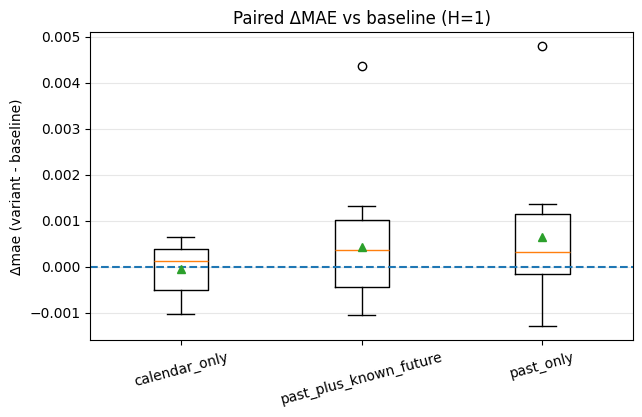

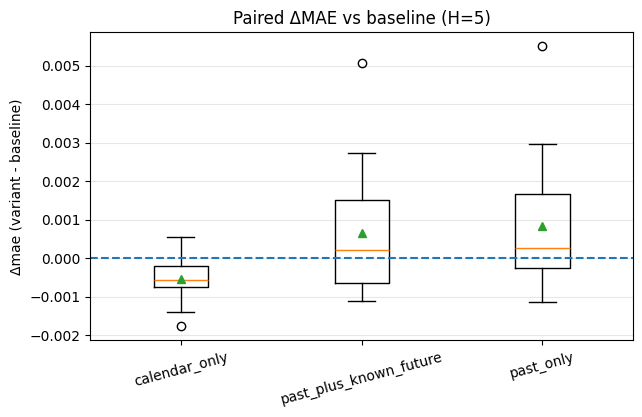

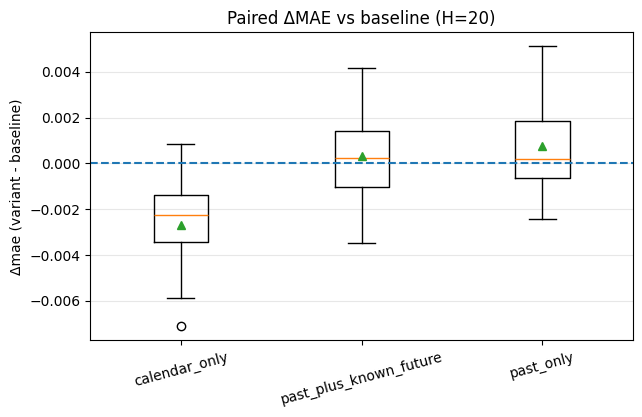

In [103]:
def boxplot_deltas(df_d: pd.DataFrame, horizon: int, metric: str='mae'):
    sub = df_d[(df_d['horizon']==horizon) & (df_d['variant']!='baseline')].copy()
    sub = sub[sub['variant'].isin(['calendar_only','past_plus_known_future','past_only'])]

    order = ['calendar_only','past_plus_known_future','past_only']
    data = [sub[sub['variant']==v][f'delta_{metric}'].values for v in order]

    plt.figure(figsize=(7,4))
    plt.boxplot(data, tick_labels=order, showmeans=True)
    plt.axhline(0, linestyle='--')
    plt.title(f'Paired Δ{metric.upper()} vs baseline (H={horizon})')
    plt.ylabel(f'Δ{metric} (variant - baseline)')
    plt.xticks(rotation=15)
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

for H in sorted(logp['horizon'].unique()):
    boxplot_deltas(logp_d, horizon=H, metric='mae')


### 2) Forest plot of mean deltas with 95% CI

A compact, report-friendly view: one line per variant for each horizon.


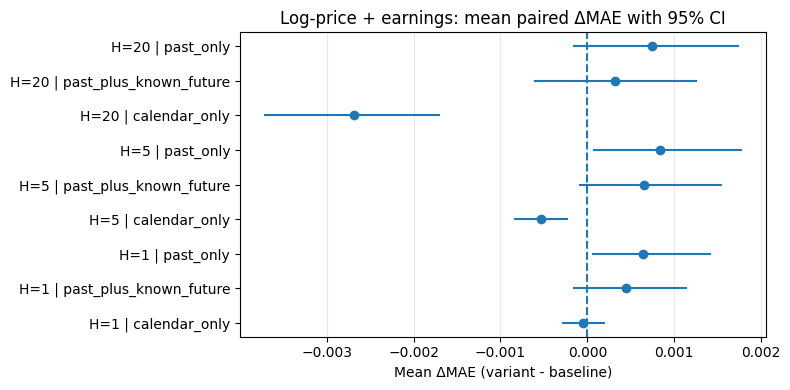

In [104]:
def forest_plot(ci_df: pd.DataFrame, title: str):
    # Build a y-axis ordering: horizon blocks
    ci_df = ci_df.copy()
    ci_df['label'] = ci_df.apply(lambda r: f"H={int(r['horizon'])} | {r['variant']}", axis=1)

    # sort by horizon then mean
    ci_df = ci_df.sort_values(['horizon','mean_delta'])
    y = np.arange(len(ci_df))

    plt.figure(figsize=(8, max(4, 0.35*len(ci_df))))
    plt.errorbar(ci_df['mean_delta'], y,
                 xerr=[ci_df['mean_delta']-ci_df['ci_lo'], ci_df['ci_hi']-ci_df['mean_delta']],
                 fmt='o')
    plt.axvline(0, linestyle='--')
    plt.yticks(y, ci_df['label'])
    plt.xlabel('Mean ΔMAE (variant - baseline)')
    plt.title(title)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

forest_plot(ci_df, title='Log-price + earnings: mean paired ΔMAE with 95% CI')


### 3) Paired scatter (baseline vs variant)

For a fixed horizon (e.g., **H=20**), we plot per-cutoff performance:
- x = baseline MAE
- y = variant MAE

Points below the diagonal mean the variant improves over baseline.


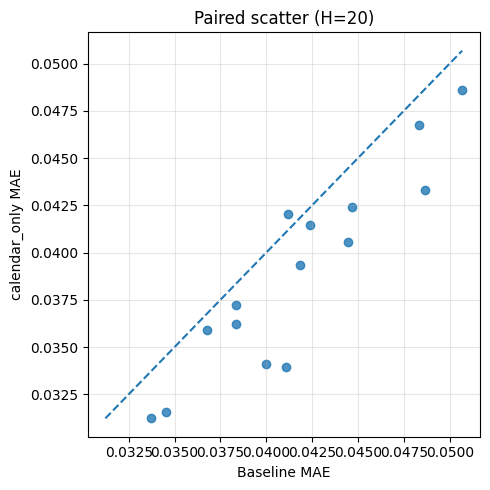

In [105]:
def paired_scatter(df: pd.DataFrame, horizon: int, variant: str, metric: str='mae'):
    sub = df[(df['horizon']==horizon) & (df['variant'].isin(['baseline', variant]))].copy()
    base = sub[sub['variant']=='baseline'].set_index('cutoff')[metric]
    var  = sub[sub['variant']==variant].set_index('cutoff')[metric]
    common = base.index.intersection(var.index)
    base, var = base.loc[common], var.loc[common]

    plt.figure(figsize=(5,5))
    plt.scatter(base.values, var.values, alpha=0.8)

    lo = min(base.min(), var.min())
    hi = max(base.max(), var.max())
    plt.plot([lo, hi], [lo, hi], linestyle='--')

    plt.xlabel(f'Baseline {metric.upper()}')
    plt.ylabel(f'{variant} {metric.upper()}')
    plt.title(f'Paired scatter (H={horizon})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

paired_scatter(logp, horizon=20, variant='calendar_only', metric='mae')


## Notes / interpretation

- Differences across variants are typically small, so **paired deltas + CI** are much more informative than raw means.
- If the forest plot’s CI is mostly below 0, the improvement is both consistent and easy to justify.
- If `calendar_only` performs well, it supports the claim that **known-future covariates** (calendar + earnings-window) can be useful without relying on technical indicators.

Next: use `03_e1_returns_vs_logprice_comparison.ipynb` to compare this dataset against the returns-target experiment using the same backtest settings.
